<a href="https://colab.research.google.com/github/fabiobento/dnn-course-2024-1/blob/main/00_course_folder/adv_cv/class_1/8%20-%20%20Laborat%C3%B3rio/C3_W1_Lab_2_Transfer_Learning_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

adaptado de [Visão computacional avançada com TensorFlow](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow?specialization=tensorflow-advanced-techniques) de [Laurence Moroney](https://laurencemoroney.com/) e [Andrew Ng](https://www.coursera.org/instructor/andrewng) , [DeepLearning.AI](https://www.deeplearning.ai/)




# Aprendizagem por Transferência de modelo disponível no Keras

Neste notebook, você executará a aprendizagem por transferência para treinar o conjunto de dados [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) no modelo ResNet50 disponível no Keras.

## Importações

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version só existe no Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow versão " + tf.__version__)

2024-04-19 20:56:50.858420: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 20:56:50.880787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 20:56:50.880815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 20:56:50.880834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 20:56:50.885731: I tensorflow/core/platform/cpu_feature_g

Tensorflow versão 2.14.0


## Parâmetros

- Definir o tamanho do lote
- Definir os nomes das classes (categorias)

In [2]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Defina algumas funções que o ajudarão a criar algumas visualizações. (Elas serão usadas mais tarde)

In [3]:
#@title Utilitários de Visualização[ME EXECUTE]
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Fontes Matplotlib
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# Utilitário para exibir uma linha de dígitos com suas previsões
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# Utilitário para exibir curvas de treinamento e validação
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Carregando e pré-processando dados

O conjunto de dados [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) tem 32 x 32 imagens RGB pertencentes a 10 classes.

Você carregará o conjunto de dados do Keras.

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

### Visualizar o conjunto de dados

Use o `display_image` para visualizar algumas das imagens e seus rótulos de classe.

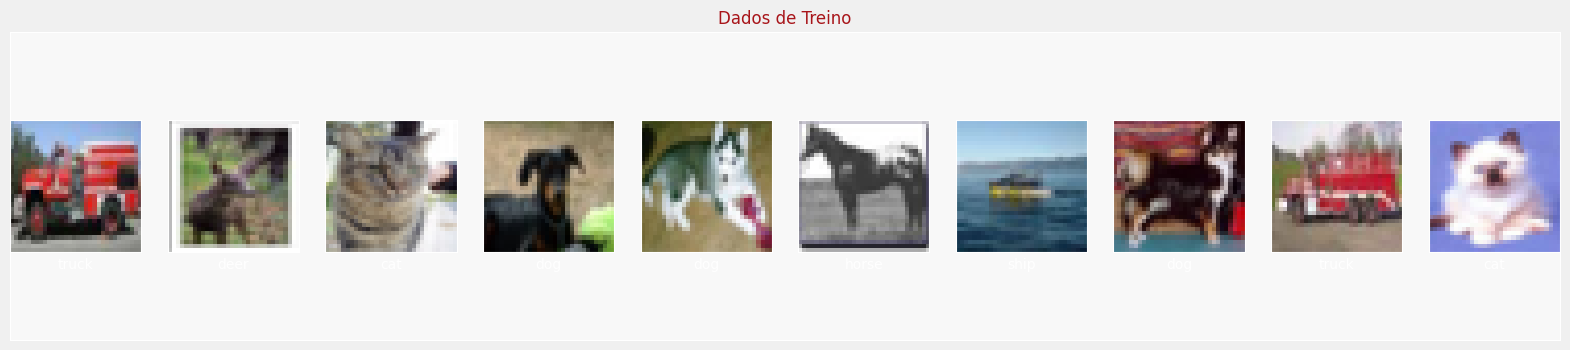

In [5]:
display_images(training_images, training_labels, training_labels, "Dados de Treino" )

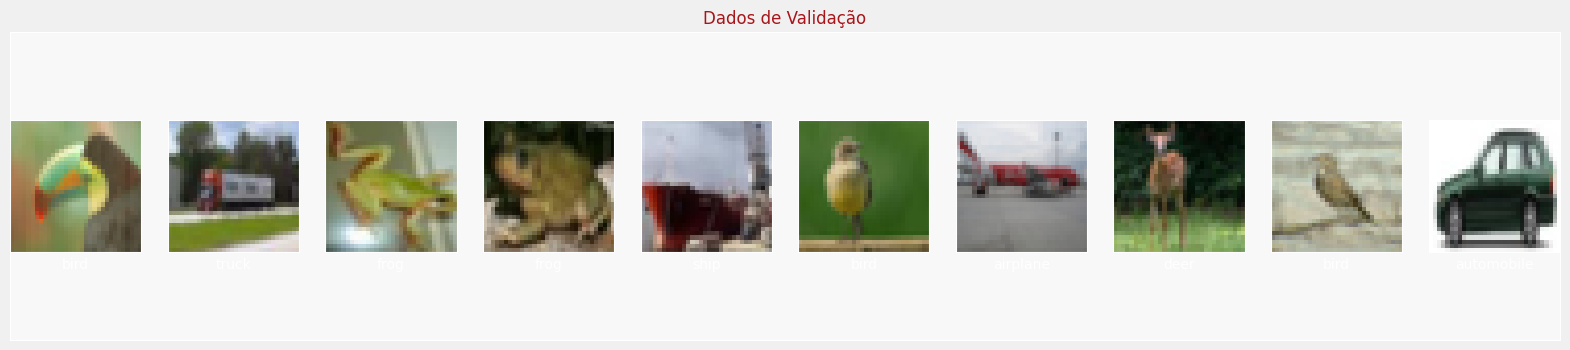

In [6]:
display_images(validation_images, validation_labels, validation_labels, "Dados de Validação" )

In [7]:
validation_images[0].astype('float32').shape

(32, 32, 3)

### Pré-processamento do conjunto de dados

Aqui, você realizará a normalização das imagens no conjunto de treinamento e validação. 
- Você usará a função [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) do modelo ResNet50 no Keras.

In [8]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [9]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Definir a rede
Você realizará a aprendizagem por transferência na **ResNet50** disponível no Keras.
- Você carregará pesos **imagenet** pré-treinados para o modelo.
- Você optará por manter todas as camadas da **ResNet50** junto com as camadas de classificação final.

In [ ]:
'''
A extração de características é realizada pelo ResNet50 pré-treinado em pesos de imagenet. 
O tamanho da entrada é 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Define as camadas densas finais e a camada softmax subsequente para classificação.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Como o tamanho da imagem de entrada é (32 x 32), primeiro amplie a imagem por um fator de (7x7) para transformá-la em (224 x 224)
Conecte as camadas de extração de recursos e "classificador" para criar o modelo.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Defina o modelo e compile-o. 
Use o Stochastic Gradient Descent como otimizador.
Use Sparse Categorical CrossEntropy como função de perda.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

## Treinar o modelo

In [15]:
# Isso levará cerca de 20 minutos para ser concluído
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

## Avaliar o modelo

Calcule as métricas de perda e precisão usando a função `.evaluate` do modelo.

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

### Traçar curvas de perda e precisão

Trace a perda (em azul) e a perda de validação (em verde).

In [ ]:
plot_metrics("loss", "Loss")

Trace a precisão do treinamento (azul), bem como a precisão da validação (verde).

In [ ]:
plot_metrics("accuracy", "Accuracy")

### Visualizar previsões
Você pode dar uma olhada nas previsões do conjunto de validação.

In [ ]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Previsões ruins indicadas em vermelho.")